## Questions:

We have limited data on these merchants and their transactions, but we are still interested in understanding their payments activity to try to infer the types of merchants using Stripe. Using only the given data, how would you identify different kinds of businesses in the sample? Please generate assignments for each merchant.

Sometimes a merchant may stop processing with Stripe, which we call churn. We are interested in identifying and predicting churn. 
Please 

a) come up with a concrete definition for churn 

b) identify merchants that have already churned in the dataset, and 

c) build a model to predict which active merchants are most likely to churn in the near future.



In [1]:
#warnings
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# use pandas to read cvs file
import pandas as pd
import datetime
# preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# model & Selection
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Check the data

In [2]:
#use pandas to look the data
df=pd.read_csv('takehome_ds_written.csv',index_col=0)
df.head()

,merchant,time,amount_usd_in_cents
1,faa029c6b0,2034-06-17 23:34:14,6349
2,ed7a7d91aa,2034-12-27 00:40:38,3854
3,5608f200cf,2034-04-30 01:29:42,789
4,15b1a0d61e,2034-09-16 01:06:23,4452
5,4770051790,2034-07-22 16:21:42,20203


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1513719 entries, 1 to 1513719
Data columns (total 3 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   merchant             1513719 non-null  object
 1   time                 1513719 non-null  object
 2   amount_usd_in_cents  1513719 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 46.2+ MB


In [4]:
# check the total size and the number of unique merchant of the dataset
print('the merchant''s total shape is', df['merchant'].shape)
print('the merchant''s unique shape is',df['merchant'].unique().shape)

the merchants total shape is (1513719,)
the merchants unique shape is (14351,)



## Get deep intp the merchant feature
    * convert 'time' to datetime
    * convert cent to dollar
    * groupby the merchant by 'amount_usd
    * groupby the merchant by 'time
    * get the period which is the start and last date and total using period of each merchant

In [5]:
# convert 'time' to datetime
df['time']=pd.to_datetime(df['time'])

# convert cent to dollar
df['amount_usd']=df['amount_usd_in_cents']/100

# the average transaction amount and total transaction times of each merchant
df_merchant=pd.DataFrame(df.groupby('merchant')['amount_usd'].agg(['sum','mean','count']))

# the start and last date and total using period of each merchant
df_period=pd.DataFrame(df.groupby('merchant')['time'].agg(['min','max']))
df_period['Period']=(df_period['max']-df_period['min']).dt.days + 1

df1=pd.concat([df_period,df_merchant],axis=1).rename(columns={'sum':'Total_Expense','min':'start_date','max':'last_date',
                                                   'mean':'Average_expense_daily','count':'total_days'})

#head 5
df1.head()

,start_date,last_date,Period,Total_Expense,Average_expense_daily,total_days
merchant,,,,,,
0002b63b92,2033-05-16 20:07:57,2033-05-16 20:07:57,1,33.79,33.790000,1
0002d07bba,2034-10-11 17:02:26,2034-12-15 09:56:19,65,892.78,223.195000,4
00057d4302,2033-05-30 01:30:52,2033-08-04 04:26:40,67,295.21,10.543214,28
000bcff341,2033-08-09 20:18:36,2033-08-09 20:18:36,1,78.26,78.260000,1
000ddbf0ca,2033-06-02 13:25:12,2033-06-02 13:25:12,1,102.99,102.990000,1


## Define 3 new columns depend on Days
* Frequency: One order every few days on average = (Period)/(total_days)
* Freshness: The number of days since the merchant has been using the app = '2035-1-1' - Start_Date
* Recency: The number of days since the last purchase time = '2035-1-1' - Last_Date

In [6]:
# calculate the "Frequency"
df1['Frequency']=round(df1['Period']/df1['total_days']+1,3)

# calculate the "Freshness"
df1['Freshness']=(datetime.datetime(2035,1,1,0,0,0)-df1['start_date']).dt.days +1

# calculate the "Recency"
df1['Recency']=(datetime.datetime(2035,1,1,0,0,0)-df1['last_date']).dt.days + 1

df2=df1.drop(columns=['start_date','last_date', 'total_days'])

#head 10
df2.head()

,Period,Total_Expense,Average_expense_daily,Frequency,Freshness,Recency
merchant,,,,,,
0002b63b92,1,33.79,33.790000,2.000,595,595
0002d07bba,65,892.78,223.195000,17.250,82,17
00057d4302,67,295.21,10.543214,3.393,581,515
000bcff341,1,78.26,78.260000,2.000,510,510
000ddbf0ca,1,102.99,102.990000,2.000,578,578


# data analysis

In [7]:
df2.describe()

,Period,Total_Expense,Average_expense_daily,Frequency,Freshness,Recency
count,14351.000000,1.435100e+04,14351.000000,14351.000000,14351.000000,14351.000000
mean,200.478085,1.633296e+04,381.045794,15.386785,337.881054,137.961605
std,203.849367,6.431726e+04,1415.186160,24.413067,205.578134,174.498650
min,1.000000,2.010000e+00,2.010000,1.000000,1.000000,1.000000
25%,18.000000,3.626300e+02,57.381817,2.000000,159.000000,11.000000
50%,128.000000,1.602620e+03,109.650000,6.000000,326.000000,52.000000
75%,349.000000,8.230995e+03,273.212222,17.600000,510.000000,214.000000
max,729.000000,2.369072e+06,88874.651667,363.500000,730.000000,729.000000


## Draw the every column plot

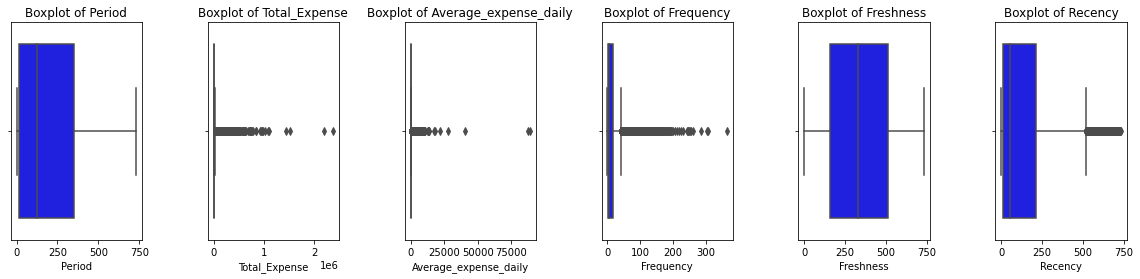

In [8]:
plt.figure(1 , figsize = (20 , 4))
n = 0 
for x in df2.columns:
    n += 1
    plt.subplot(1 , 6 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.boxplot(df2[x],color="blue")
    plt.title('Boxplot of {}'.format(x))
plt.show()

<AxesSubplot:>

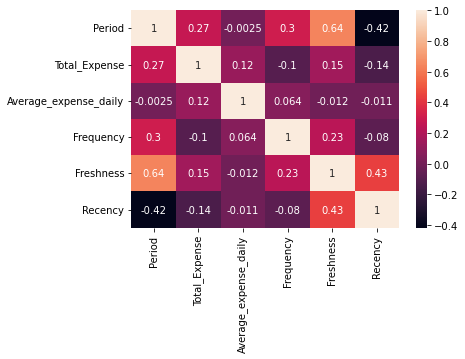

In [9]:
sns.heatmap(df2.corr(),annot=True)

### Conclusion:
The features are mostly positively skewed according to the distribution plot

Most of the features are little correlated with each other according to the heatmap

So for next step we need to use cluster method to cluser the data

In [10]:
'''
    Use Unsuprvised learning algorithm KMeans to cluster the data

'''

# scale the data
scaler=StandardScaler() 
scaler.fit(df2) #out: standardscaler(copy = true, with_mean = true, with_std = true)
df2_scale=scaler.transform(df2) #out: array

#dataframe
df2scale=pd.DataFrame(df2_scale,columns=['Period','Total_Expense','Average_expense_daily',
                                         'Frequency','Freshness','Recency'])
df2scale.head()

,Period,Total_Expense,Average_expense_daily,Frequency,Freshness,Recency
0,-0.978590,-0.253427,-0.245387,-0.548364,1.250755,2.619243
1,-0.664622,-0.240071,-0.111545,0.076323,-1.244733,-0.693219
2,-0.654811,-0.249362,-0.261814,-0.491303,1.182652,2.160770
3,-0.978590,-0.252736,-0.213962,-0.548364,0.837273,2.132116
4,-0.978590,-0.252351,-0.196487,-0.548364,1.168059,2.521817


In [11]:
# using "inertia" and "silhouette_avg" to select the best parameter "n_clusters"
inertia = []
silhouette_avg = []
for n in range(2 ,20):
    cluster = KMeans(n_clusters = n ,init='k-means++', 
                     tol=0.0001,  random_state= 111  , algorithm='elkan')  # n_init = 10
    cluster.fit(df2_scale)
    inertia.append(cluster.inertia_)#sum up inertia
    silhouette_avg.append(silhouette_score(df2_scale,cluster.labels_)) #.labels_ get the cluster label

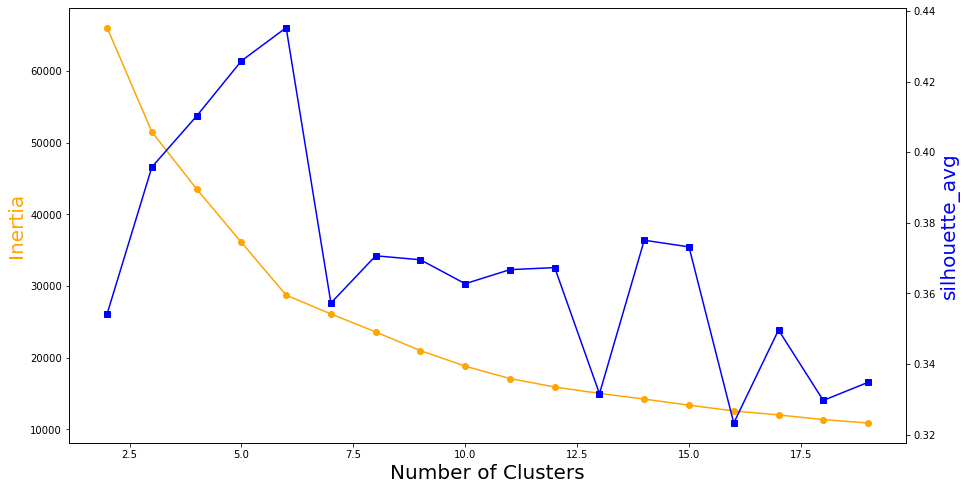

In [12]:
fig,ax = plt.subplots(1 , figsize = (15 ,8))
ax.plot(np.arange(2 , 20) , inertia , 'o', color='orange')
ax.plot(np.arange(2 , 20) , inertia , '-' , alpha = 1 , color='orange')
ax.set_xlabel('Number of Clusters',fontsize=20)
ax.set_ylabel('Inertia',color='orange',fontsize=20)

ax2=ax.twinx()
ax2.plot(np.arange(2 , 20) , silhouette_avg , 's', color="blue")
ax2.plot(np.arange(2 , 20) , silhouette_avg , '-' , alpha = 1, color="blue" )
ax2.set_ylabel('silhouette_avg',color="blue",fontsize=20)


plt.show()

In [13]:
# use "n_clusters=6" as the model parameter
cluster = KMeans(n_clusters = 6 ,init='k-means++', 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') 
cluster.fit(df2_scale)
labels = cluster.labels_
centroids = cluster.cluster_centers_

In [14]:
# see the number of merchants in each cluster
df2scale['label']=labels
df2scale.groupby('label').agg('count').iloc[:,0]
df2scale

,Period,Total_Expense,Average_expense_daily,Frequency,Freshness,Recency,label
0,-0.978590,-0.253427,-0.245387,-0.548364,1.250755,2.619243,3
1,-0.664622,-0.240071,-0.111545,0.076323,-1.244733,-0.693219,1
2,-0.654811,-0.249362,-0.261814,-0.491303,1.182652,2.160770,3
3,-0.978590,-0.252736,-0.213962,-0.548364,0.837273,2.132116,3
4,-0.978590,-0.252351,-0.196487,-0.548364,1.168059,2.521817,3
...,...,...,...,...,...,...,...
14346,-0.870664,-0.242660,-0.166623,-0.400897,1.892869,3.243911,3
14347,0.296906,-0.210165,-0.231717,-0.387584,1.158330,1.020321,3
14348,0.659931,-0.104825,-0.185591,-0.419904,0.180565,-0.555678,5
14349,-0.880475,-0.251475,-0.231732,-0.302586,0.015172,1.048975,3


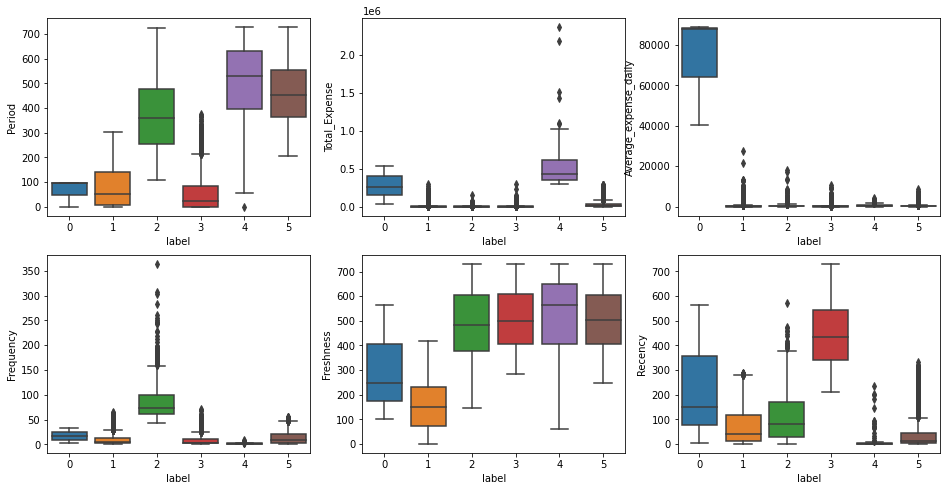

In [15]:
# boxplot to see distribution on each cluster
df2['label']=labels
name=locals()
fig,((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3, figsize = (16,8))
for i in range(6):
    sns.boxplot(x='label', y=df2.iloc[:,i], data=df2,ax=name['ax'+str(i)])

# Semi-Comment:
|   label   | Period | Total_Expense | Average_expense_daily | Frequency | Freshness | Recency | Characteristics| Active merchant|
| :----: | :----: |  :----:          | :----:             | :----:       | :----:      |:----:     |:----  |:----  |
| 1      | slightly shorter  | small | mostly small | high-frequency |new| mostly short|New customers with high-frequency of use services and kind of good expense ability(Average_expense_daily)|Very active|
| 4      | mostly long  | large| small| very high-frequency| mostly old | short| Old customers who keep using with high-frequency of use services and small expense ability(Average_expense_daily), but large total amount|active|
| 2      | long  | small| mostly small<br/>some large| low-frequency | old | mostly short| Old customers with low-frequency of use services and kind of good expense ability(Average_expense_daily)|relative active|
| 5      | long| small| small |slightly low-frequency | old | short |Old customers who keep using with low-frequency of use services and small expense ability(Average_expense_daily)|relative active|
| 3     | mostly short  | mostly small | small | low-frequency| old | long |Old customers who have not used for a long time with low-frequency of use and low expense ability(Average_expense_daily)|No|
| 0   | short |  slightly larger | very large | high-frequency | relatively new |relatively long| Special Customers who only use service in a very short period with large expense amount | Special|



# Question: come up with a concrete definition for churn 

### Guess: From the conclusion above  two merchants may have not used Stripe for the same days,the merchant with “low-frequency ” may be more likely to have been churned compared to the merchant with “high-frequency”.  The longer using period is, the more likely user rely on Stripe.


##  $ChurnRate=\frac{Recency}{Frequency}$<br/> $ChurnScore = \frac{1}{2}ChurnRate + \frac{1}{2}\frac{100}{Period}$

In [16]:
df2['ChurnScore']=0.5*df2['Recency']/df2['Frequency']+50/df2['Period']
print(df2['ChurnScore'].describe())
print('80% Quantile: '+str(df2['ChurnScore'].quantile(0.8)))

count    14351.000000
mean        31.085130
std         56.976897
min          0.074468
25%          0.810949
50%          3.215008
75%         33.589646
max        396.634615
Name: ChurnScore, dtype: float64
80% Quantile: 55.25


In [17]:
df2['Churn']=np.where(df2['ChurnScore']>df2['ChurnScore'].quantile(0.8),1,0) #churned: 1# not churend:0
df2.groupby('Churn').agg('count').iloc[:,0]

Churn
0    11482
1     2869
Name: Period, dtype: int64

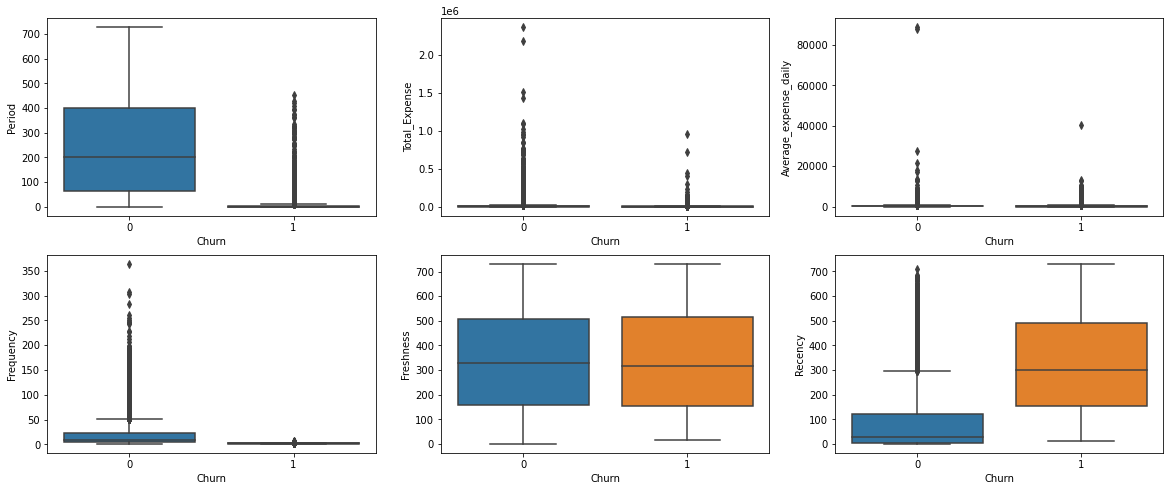

In [18]:
#boxplot
fig,((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3, figsize = (20,8))
for i in range(6):
    sns.boxplot(x='Churn', y=df2.iloc[:,i], data=df2,ax=name['ax'+str(i)])

In [19]:
# the churned merchant
df2[df2['Churn']==1].describe()

,Period,Total_Expense,Average_expense_daily,Frequency,Freshness,Recency,label,ChurnScore,Churn
count,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.0
mean,14.059603,4636.451941,403.214590,1.935873,335.941094,322.655629,2.083653,126.176998,1.0
std,43.572391,28907.847904,1252.662174,0.656274,208.863087,199.686216,1.017271,65.820632,0.0
min,1.000000,2.090000,2.060000,1.000000,15.000000,14.000000,0.000000,55.281411,1.0
25%,1.000000,123.250000,52.990000,1.500000,154.000000,153.000000,1.000000,74.750000,1.0
50%,1.000000,366.730000,106.335000,2.000000,317.000000,302.000000,3.000000,106.442308,1.0
75%,5.000000,1633.150000,269.460000,2.000000,514.000000,490.000000,3.000000,160.666667,1.0
max,455.000000,957098.710000,40475.210000,6.500000,730.000000,729.000000,5.000000,396.634615,1.0


In [20]:
df2.groupby('label').agg('count').iloc[:,1]

label
0       3
1    6786
2     957
3    2723
4     116
5    3766
Name: Total_Expense, dtype: int64

In [21]:
df2[df2['Churn']==1].groupby('label').agg('count').iloc[:,1]

label
0       1
1    1328
3    1523
4       4
5      13
Name: Total_Expense, dtype: int64

# Build up the churn model

In [22]:
# get dummy variables for "label" ----> the type we got from the previous segmentation
df2['label']=df2['label'].astype('category')
df_dummies = pd.get_dummies(df2)
X=df_dummies.drop(columns=['Churn','ChurnScore']).copy()
y=df_dummies['Churn'].copy()

In [23]:
# upsampling the "churn" class
oversample = SMOTE()
X_os, y_os = oversample.fit_resample(X, y)
print(X.shape, y.shape)
print(X_os.shape, y_os.shape)

(14351, 12) (14351,)
(22964, 12) (22964,)


In [24]:
# scale the data
scale2=StandardScaler()
scale2.fit(X)
X_scale=scale2.transform(X_os)

dfXscale=pd.DataFrame(X_scale,columns=['Period','Total_Contribution','Contribution_Ability',
                                          'Fequency','Freshness','Recency',
                                          'label_0','label_1','label_2','label_3','label_4','label_5'])
dfXscale

,Period,Total_Contribution,Contribution_Ability,Fequency,Freshness,Recency,label_0,label_1,label_2,label_3,label_4,label_5
0,-0.978590,-0.253427,-0.245387,-0.548364,1.250755,2.619243,-0.01446,-0.947114,-0.267301,2.066468,-0.090271,-0.596478
1,-0.664622,-0.240071,-0.111545,0.076323,-1.244733,-0.693219,-0.01446,1.055839,-0.267301,-0.483917,-0.090271,-0.596478
2,-0.654811,-0.249362,-0.261814,-0.491303,1.182652,2.160770,-0.01446,-0.947114,-0.267301,2.066468,-0.090271,-0.596478
3,-0.978590,-0.252736,-0.213962,-0.548364,0.837273,2.132116,-0.01446,-0.947114,-0.267301,2.066468,-0.090271,-0.596478
4,-0.978590,-0.252351,-0.196487,-0.548364,1.168059,2.521817,-0.01446,-0.947114,-0.267301,2.066468,-0.090271,-0.596478
...,...,...,...,...,...,...,...,...,...,...,...,...
22959,-0.929533,-0.244347,-0.246146,-0.561502,1.289671,2.602050,-0.01446,-0.947114,-0.267301,2.066468,-0.090271,-0.596478
22960,-0.836324,-0.223751,-0.226838,-0.549707,0.321636,1.352713,-0.01446,-0.947114,-0.267301,2.066468,-0.090271,-0.596478
22961,-0.978590,-0.249131,-0.159695,-0.568846,-1.264191,-0.343634,-0.01446,1.055839,-0.267301,-0.483917,-0.090271,-0.596478
22962,-0.978590,-0.250856,-0.128544,-0.548364,0.598912,1.851302,-0.01446,-0.947114,-0.267301,2.066468,-0.090271,-0.596478


In [25]:
# split train and test set
X_train,X_test, y_train, y_test=train_test_split(dfXscale, y_os,test_size=0.3,random_state=42)

In [26]:
# Random Forest ---- tuning the parameters
para_RF={'max_depth':range(2,6),'n_estimators':[100,300,500]}
scoring = 'accuracy'
RFmodel = RandomForestClassifier(max_features=6)

RFgrid=GridSearchCV(RFmodel, param_grid=para_RF, cv=5, scoring=scoring)
RFgrid.fit(X_os, y_os)

print('Best Accuracy Score = '+str(RFgrid.best_score_))
print('Best Parameters = '+str(RFgrid.best_params_))

Best Accuracy Score = 0.9928148500482858
Best Parameters = {'max_depth': 5, 'n_estimators': 100}


In [27]:
# Random Forest ---- Select the best parameters and calculate the test score
RFmodel = RandomForestClassifier(max_depth=5, n_estimators=500)
RFmodel.fit(X_train, y_train)
RF_pred=RFmodel.predict(X_test)
print(classification_report(y_test, RF_pred, digits=5))
print(pd.crosstab(y_test, RF_pred))

              precision    recall  f1-score   support

           0    0.99528   0.98081   0.98799      3439
           1    0.98115   0.99536   0.98820      3451

    accuracy                        0.98810      6890
   macro avg    0.98821   0.98809   0.98810      6890
weighted avg    0.98820   0.98810   0.98810      6890

col_0     0     1
Churn            
0      3373    66
1        16  3435


In [28]:
# XGBoost ---- tuning the parameters
para_XGB={'max_depth':range(2,6),
         'n_estimators': [100,300,500],
         'learning_rate': [0.01,0.05,0.1,0.2]}
scoring = 'accuracy'
XGBmodel = XGBClassifier(eval_metric='logloss')

XGBgrid=GridSearchCV(XGBmodel, param_grid=para_XGB, cv=5, scoring=scoring)
XGBgrid.fit(X_os, y_os)

print('Best Accuracy Score = '+str(XGBgrid.best_score_))
print('Best Accuracy Score = '+str(XGBgrid.best_params_))

Best Accuracy Score = 0.9981274716638179
Best Accuracy Score = {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 500}


In [29]:
# XGBoost ---- Select the best parameters and calculate the test score
XGBmodel = XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.2, eval_metric='logloss')
XGBmodel.fit(X_train, y_train)
XGB_pred=XGBmodel.predict(X_test)
print(classification_report(y_test, XGB_pred, digits=5))
print(pd.crosstab(y_test, XGB_pred))

              precision    recall  f1-score   support

           0    0.99709   0.99767   0.99738      3439
           1    0.99768   0.99710   0.99739      3451

    accuracy                        0.99739      6890
   macro avg    0.99739   0.99739   0.99739      6890
weighted avg    0.99739   0.99739   0.99739      6890

col_0     0     1
Churn            
0      3431     8
1        10  3441


### Model Conclusions: According to the "Accuracy", "Recall", "Precision" above, we choose the XGBoost model
  a) If we just want to try our best to identtify as much as possible churned merchants and do not care about other factors(i.e. cost), we may need to select the model with the highest "Recall".
  
  b) If the cost of saving a merchant is very high or the way we saving a merchant may affect other merchants' interest(i.e. sending too much subscribtion emails), we may need to select the model with higher "Precision".

# make a perdiction on unchurned merchant

In [30]:
# extract active merchants
df_act=df2[df2['Churn']==0]
df_act

,Period,Total_Expense,Average_expense_daily,Frequency,Freshness,Recency,label,ChurnScore,Churn
merchant,,,,,,,,,
0002d07bba,65,892.78,223.195000,17.250,82,17,1,1.261984,0
000ed1585f,657,16472.67,265.688226,11.597,682,26,5,1.197083,0
000f8c3297,457,34551.91,119.144517,2.576,459,2,5,0.497608,0
0020aefbd9,23,130.04,65.020000,12.500,216,193,1,9.893913,0
0026f256ac,89,2508.78,313.597500,12.125,562,473,3,20.066952,0
...,...,...,...,...,...,...,...,...,...
ffd3284f86,14,805.86,80.586000,2.400,15,2,1,3.988095,0
ffe1f6b51a,261,2816.16,53.135094,5.925,576,316,3,26.858238,0
ffe26b900d,335,9591.13,118.409012,5.136,375,41,5,4.140687,0


In [31]:
# get dummise for "label"
act_df_dummies = pd.get_dummies(df_act)
X_act=act_df_dummies.drop(columns=['Churn','ChurnScore']).copy()
y_act=act_df_dummies['Churn'].copy()

In [32]:
# scale the data
scale3=StandardScaler()
scale3.fit(X_act)
X_scale_act=scale2.transform(X_act)

In [33]:
# make prediction with XGBoost model above
XGB_pred_act=XGBmodel.predict(X_scale_act)
df_act['Predict']=XGB_pred_act

# show which merchants are predicted to be more likely to churn in the near future
df_act[df_act['Predict']==1]

,Period,Total_Expense,Average_expense_daily,Frequency,Freshness,Recency,label,ChurnScore,Churn,Predict
merchant,,,,,,,,,,
09689dc3f0,69,1358.78,67.939000,4.450,550,482,3,54.881941,0,1
5519880667,17,11474.52,1434.315000,3.125,339,322,3,54.461176,0,1
77586d88d9,8,8457.55,291.639655,1.276,122,115,1,51.312696,0,1
826d94dbc5,20,568.31,71.038750,3.500,356,337,3,50.642857,0,1
9f0508694f,30,4947.91,72.763382,1.441,178,148,1,53.019894,0,1
e7f4855acd,28,920.45,131.492857,5.000,558,530,3,54.785714,0,1
eb6cafa141,388,248161.88,1204.669320,2.883,698,310,5,53.892307,0,1
f020b29644,55,2072.98,94.226364,3.500,423,368,3,53.480519,0,1


# Conclusions:
### we can see from the prediction, most of the merchants who are predicted to churn belong to "label 3", which is consistant with the initial guess we made before.
### There are some merchants belong to "label 1" we still need to pay attention to them, or they may churn in the near future.